In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -*- coding: utf-8 -*-
"""
[Final Project] MVTecAD Classification – Colab 스크립트 (inline 시각화)
---------------------------------------------------------------------
• mask 파일 제외, 3채널 강제 변환
• 학습 종료 후 별도의 함수 호출 없이 바로 시각화 코드 실행
"""

from google.colab import drive
drive.mount("/content/drive")

# ==================================================
# 0. 의존성 & 전역 설정
# ==================================================
import os, random, time
from pathlib import Path
from typing import List, Tuple

import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------------
# 사용자 하이퍼파라미터
# ------------------------------
ROOT_DIR   = "/content/drive/MyDrive/Data/MVTecAD"  # 데이터셋 경로
IMG_SIZE   = 224
BATCH_SIZE = 32
VAL_RATIO  = 0.2
EPOCHS     = 10
LR         = 1e-4
SEED       = 2025
BEST_PATH  = "best_model.pt"

# --------------------------------------------------
# 시드 고정
# --------------------------------------------------
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ 사용 디바이스:", DEVICE)

# ==================================================
# 1. Dataset (mask 제외 + 3채널 변환)
# ==================================================
class MVTecClsDataset(Dataset):
    """MVTecAD 전체 구조(train+test)를 한 번에 스캔해
    `category_defect` 단위 클래스로 만드는 Dataset.
    • train/ 하위는 항상 `good` 이므로 라벨 = f"{category}_good"
    • test/ 하위는 결함 폴더(예: broken_large)를 그대로 라벨에 사용
    • 파일명에 `mask` 포함 시 제외
    • 모든 이미지는 3채널(RGB)로 강제 변환
    """

    VALID_EXT = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    HIDDEN    = {".ipynb_checkpoints", ".DS_Store"}

    def __init__(self, root_dir: str, transforms=None):
        self.root = Path(root_dir)
        self.t    = transforms
        self.samples: List[Tuple[Path, int]] = []
        self.classes: List[str] = []
        self._scan()

    def _scan(self):
        lbl2idx = {}
        for p in self.root.rglob("*"):
            # --- 유효 파일 필터 ---
            if not (p.is_file() and p.suffix.lower() in self.VALID_EXT):
                continue
            if any(h in p.parts for h in self.HIDDEN):
                continue
            if "mask" in p.stem.lower():
                continue
            parts = p.relative_to(self.root).parts  # (category, train/test, defect?, img)
            if len(parts) < 3:
                continue
            category, phase = parts[0], parts[1]
            defect = "good" if phase == "train" else parts[2]
            lbl_name = f"{category}_{defect}"
            cls_idx = lbl2idx.setdefault(lbl_name, len(lbl2idx))
            self.samples.append((p, cls_idx))

        self.classes = [lbl for lbl, _ in sorted(lbl2idx.items(), key=lambda kv: kv[1])]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, label = self.samples[idx]
        img = torchvision.io.read_image(str(p)).float() / 255.0
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        elif img.shape[0] == 4:
            img = img[:3]
        if self.t:
            img = self.t(img)
        return img, label, str(p)


# ==================================================
# 2. DataLoader
# ==================================================
train_tfms=T.Compose([T.Resize((IMG_SIZE,IMG_SIZE)), T.RandomHorizontalFlip(), T.RandomRotation(10)])
val_tfms=T.Resize((IMG_SIZE,IMG_SIZE))

base_ds=MVTecClsDataset(ROOT_DIR)
indices=list(range(len(base_ds)))

random.shuffle(indices)

val_len=int(len(indices) * VAL_RATIO)
val_idx,train_idx=indices[:val_len],indices[val_len:]
train_set, val_set = Subset(base_ds,train_idx), Subset(base_ds,val_idx)

make_loader=lambda ds,tfm,shuf: DataLoader(ds, batch_size=BATCH_SIZE,shuffle=shuf,
                                           num_workers=2 if torch.cuda.is_available() else 0,
                                           pin_memory=torch.cuda.is_available(),
                                           collate_fn=lambda b:(torch.stack([tfm(x[0]) for x in b]),
                                                                torch.tensor([x[1] for x in b]),
                                                                [x[2] for x in b]))
train_loader = make_loader(train_set,train_tfms,True)
val_loader = make_loader(val_set,val_tfms,False)
idx2lbl=base_ds.classes
print("클래스:", idx2lbl)

# ==================================================
# 3. 모델 정의
# ==================================================
model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1]=nn.Linear(model.classifier[1].in_features, len(idx2lbl))
model=model.to(DEVICE)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=LR)

# ==================================================
# 4. 학습 루프
# ==================================================
best_acc=0.
for epoch in range(1,EPOCHS+1):
    start=time.time()
    # ----- 학습 -----
    model.train(); train_loss=0.
    for imgs,labels,_ in tqdm(train_loader,desc=f"Epoch {epoch}/{EPOCHS} - 학습",leave=False):
        imgs,labels=imgs.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad(); out=model(imgs); loss=criterion(out,labels); loss.backward(); optimizer.step()
        train_loss+=loss.item()*imgs.size(0)
    train_loss/=len(train_loader.dataset)

    # ----- 검증 -----
    model.eval(); val_loss=0.; correct=0
    with torch.inference_mode():
        for imgs,labels,_ in tqdm(val_loader,desc="검증",leave=False):
            imgs,labels=imgs.to(DEVICE),labels.to(DEVICE)
            out=model(imgs); loss=criterion(out,labels)
            val_loss+=loss.item()*imgs.size(0)
            correct+=(out.argmax(1)==labels).sum().item()
    val_loss/=len(val_loader.dataset); val_acc=correct/len(val_loader.dataset)

    print(f"[Ep {epoch}] train {train_loss:.3f} | val {val_loss:.3f} | acc {val_acc:.2%} | {time.time()-start:.1f}s")
    if val_acc>best_acc:
        best_acc=val_acc; torch.save(model.state_dict(),BEST_PATH)
        print("  🔥 Best model saved")
print("✅ 학습 완료 – 최고 정확도:", f"{best_acc:.2%}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 사용 디바이스: cuda
클래스: ['leather_color', 'leather_poke', 'leather_glue', 'leather_good', 'leather_fold', 'leather_cut', 'cable_missing_wire', 'cable_cut_outer_insulation', 'cable_good', 'cable_bent_wire', 'cable_cable_swap', 'cable_poke_insulation', 'cable_missing_cable', 'cable_combined', 'cable_cut_inner_insulation', 'capsule_good', 'capsule_crack', 'capsule_scratch', 'capsule_poke', 'capsule_faulty_imprint', 'capsule_squeeze', 'hazelnut_good', 'hazelnut_print', 'hazelnut_crack', 'hazelnut_hole', 'hazelnut_cut', 'bottle_broken_large', 'bottle_broken_small', 'bottle_contamination', 'bottle_good', 'carpet_color', 'carpet_metal_contamination', 'carpet_good', 'carpet_thread', 'carpet_cut', 'carpet_hole', 'metal_nut_color', 'metal_nut_good', 'metal_nut_scratch', 'metal_nut_bent', 'metal_nut_flip', 'screw_good', 'screw_scratch_neck', 'screw_scratch_head', 'screw_th

[Ep 1] train 1.950 | val 1.033 | acc 78.13% | 1316.0s
  🔥 Best model saved


[Ep 2] train 0.982 | val 0.805 | acc 78.41% | 118.8s
  🔥 Best model saved


[Ep 3] train 0.800 | val 0.664 | acc 81.12% | 119.3s
  🔥 Best model saved


[Ep 4] train 0.670 | val 0.563 | acc 84.11% | 119.8s
  🔥 Best model saved


[Ep 5] train 0.568 | val 0.495 | acc 86.45% | 120.2s
  🔥 Best model saved


[Ep 6] train 0.470 | val 0.418 | acc 88.13% | 119.3s
  🔥 Best model saved


[Ep 7] train 0.415 | val 0.368 | acc 90.19% | 121.8s
  🔥 Best model saved


[Ep 8] train 0.357 | val 0.338 | acc 90.65% | 118.7s
  🔥 Best model saved


[Ep 9] train 0.299 | val 0.284 | acc 92.24% | 119.1s
  🔥 Best model saved


[Ep 10] train 0.263 | val 0.309 | acc 92.06% | 124.1s
✅ 학습 완료 – 최고 정확도: 92.24%


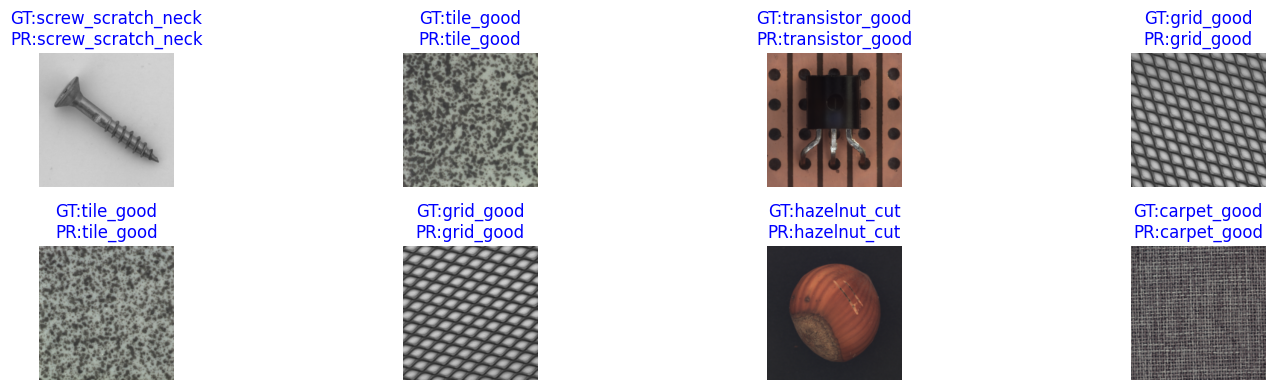

In [ ]:
# ==================================================
# 5. 시각화 (파란=정답, 빨간=오답)
# ==================================================
# 검증 배치 GT vs 예측 (색상 구분)
model.eval(); val_imgs,val_labels,_=next(iter(val_loader))
with torch.inference_mode(): preds=model(val_imgs.to(DEVICE)).argmax(1).cpu()
plt.figure(figsize=(16,4))
for i in range(8):
    correct=preds[i]==val_labels[i]; color='blue' if correct else 'red'
    plt.subplot(2,4,i+1)
    plt.imshow(val_imgs[i].permute(1,2,0))
    plt.title(f"GT:{idx2lbl[int(val_labels[i])]}\nPR:{idx2lbl[int(preds[i])]}", color=color)
    plt.axis('off')
plt.tight_layout(); plt.show()